# Light FM

use items' and users' features 

In [2]:
!dir

 磁碟區 C 中的磁碟是 SYSTEM
 磁碟區序號:  7CDE-EF88

 C:\Info_Center\DBMTeam\DBM個人資料\Ihong\RS\PlayRecommendSystem 的目錄

2017/10/06  下午 02:34    <DIR>          .
2017/10/06  下午 02:34    <DIR>          ..
2017/10/05  下午 04:19                40 .gitignore
2017/10/06  下午 02:25    <DIR>          .ipynb_checkpoints
2017/10/05  下午 04:19             4,434 01_explict_CF_intro.ipynb
2017/10/05  下午 02:41           116,025 02_explicit_ALS_SGD.ipynb
2017/10/06  下午 02:08            36,805 03_implict_ALS_sketchlab.ipynb
2017/10/06  下午 02:31             2,638 04_lightFM.ipynb
2017/10/05  下午 04:19            12,046 explict_CF.py
2017/10/05  下午 03:05             6,517 helpers.py
2017/10/06  下午 02:27    <DIR>          implicit
2017/10/05  下午 04:19    <DIR>          ml-100k
2017/10/05  下午 04:19               228 README.md
2017/10/05  下午 04:28    <DIR>          rec-a-sketch
               8 個檔案         178,733 位元組
               6 個目錄  66,611,601,408 位元組可用


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import scipy.sparse as sp
from scipy.special import expit ## ??
import pickle
import csv
import copy 
import itertools
from lightfm import LightFM
import lightfm.evaluation
import sys
import helpers
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('rec-a-sketch/model_likes_anon.psv',
                sep='|', quoting=csv.QUOTE_MINIMAL,
                quotechar = '\\')
df.drop_duplicates(inplace=True)
df.head()

,modelname,mid,uid
0,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,7ac1b40648fff523d7220a5d07b04d9b
1,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,2b4ad286afe3369d39f1bb7aa2528bc7
2,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1bf0993ebab175a896ac8003bed91b4b
3,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,6484211de8b9a023a7d9ab1641d22e7c
4,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1109ee298494fbd192e27878432c718a


In [3]:
# Threshold data to only include users and models with min 5 likes
df = helpers.threshold_interactions_df(df,'uid','mid',5,5)

Starting interactions info
Number of rows: 62583
Number of cols: 28806
Sparsity: 0.035%
Ending interactions info
Number of rows: 15274
Number of columns: 25655
Sparsity: 0.140%


In [4]:
# Go from dataframe to likes matrix 
# Also buid index to ID mappers.
likes, uid_to_idx, idx_to_uid, \
mid_to_idx, idx_to_mid = helpers.df_to_matrix(df,'uid','mid')

likes

<15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 547477 stored elements in Compressed Sparse Row format>

In [5]:
train,test,user_index = helpers.train_test_split(likes,5,0.2)

In [6]:
print(repr(train),'\n',repr(test))

<15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 532207 stored elements in Compressed Sparse Row format> 
 <15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 15270 stored elements in Compressed Sparse Row format>


To copy the training data to only include users with data in the test set.

In [7]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

## one-hot-encode  side information

In [8]:
sideinfo = pd.read_csv('./rec-a-sketch/model_feats.psv',
                      sep = '|', quoting=csv.QUOTE_MINIMAL,
                      quotechar='\\')
sideinfo.head(3)

,mid,type,value
0,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Characters
1,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Gaming
2,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,3dsmax


In [9]:
for idx,row in sideinfo.iterrows():
    if idx > 5 :
        break
    else :
        print(row.type,row.value)

category Characters
category Gaming
tag 3dsmax
tag noel
tag loli
tag anime


In [10]:
# Build list of dictionaries containing features and 
# weights in same order as idx_to_mid prescribes
feat_dlist = [{} for _ in idx_to_mid]
for idx, row in sideinfo.iterrows():
    feat_key = '{}_{}'.format(row.type, str(row.value).lower())
    idx = mid_to_idx.get(row.mid)
    if idx is not None:
        feat_dlist[idx][feat_key] = 1


In [11]:
feat_dlist[1]

{'category_characters': 1,
 'category_gaming': 1,
 'tag_leagueoflegends': 1,
 'tag_lol': 1}

In [12]:
from sklearn.feature_extraction import DictVectorizer

In [13]:
dv = DictVectorizer()
item_features = dv.fit_transform(feat_dlist)

`items - features`

In [14]:
item_features

<25655x20352 sparse matrix of type '<class 'numpy.float64'>'
	with 161510 stored elements in Compressed Sparse Row format>

## Training

Weighted Approximated Rank Pairwise on LightFM on default setting and ignore item features to start.

In [15]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)
        
def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [16]:
model = LightFM(loss='warp', random_state=2016)
# Initialize model.
model.fit(train,epochs=0);
iterarray = range(10,110,10)

model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 1}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.14231   |  0.02423   |
+------------+------------+------------+
|     20     |  0.16320   |  0.03078   |
+------------+------------+------------+
|     30     |  0.17420   |  0.03176   |
+------------+------------+------------+
|     40     |  0.17636   |  0.03274   |
+------------+------------+------------+
|     50     |  0.17420   |  0.03392   |
+------------+------------+------------+
|     60     |  0.17583   |  0.03353   |
+------------+------------+------------+
|     70     |  0.17453   |  0.03307   |
+------------+------------+------------+
|     80     |  0.17531   |  0.03255   |
+------------+------------+------------+
|     90     |  0.17367   |  0.03215   |
+------------+------------+------------+
|    100     |  0.17420   |  0.03229   |
+------------+------------+------------+


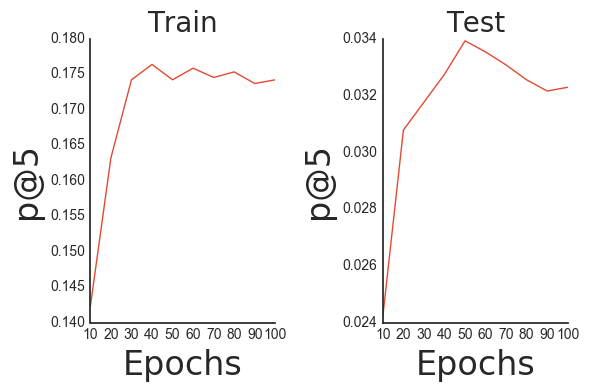

In [27]:
import seaborn as sns
sns.set_style('white')
# ?sns.set_style
def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=10);
    plt.yticks(fontsize=10);

# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

## Optimizing Hyperparameters with 
`scikit-optimize`

skip

# Learning to Rank + Side information

In [36]:
eye = sp.eye(item_features.shape[0],item_features.shape[0]).tocsr()
item_features_concat = sp.hstack((eye,item_features))
item_features_concat = item_features_concat.tocsr().astype(np.float32)

In [40]:
from skopt import forest_minimize

ImportError: No module named 'skopt'

In [39]:
def objective_wsideinfo(params):
    # unpack
    epochs, learning_rate,\
    no_components, item_alpha,\
    scale = params
    
    user_alpha = item_alpha * scale
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              item_features=item_features_concat,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              item_features=item_features_concat,
                                              train_interactions=None,
                                              k=5, num_threads=3)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Weird shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out